# Face Generation

In [1]:
%matplotlib inline

In [3]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
import PIL
import cv2
# import helper

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. Data Preprocessing

### 1.1 Dataloader

In [5]:
class Rescale:
    def __init__(self, _range=(-1,1)):
        self._range = _range

    def __call__(self, img):
        """Rescale the pixel values of an image into (-1,1) range"""
        _img = deepcopy(img)
        if isinstance(_img, PIL.Image.Image):
            _img = np.array(img) # already RGB?
        _img *= (self._range[1] - self._range[0]) + self._range[0]
        return _img

In [7]:
batch_size = 128
img_size = 32
data_dir = '/home/martin/data'

rescale = Rescale()
compose = transforms.Compose([transforms.Resize((img_size, img_size)), 
                              rescale,
                              transforms.ToTensor()])

dataset = datasets.ImageFolder(data_dir, compose)
dataloaders = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

### 1.2 Visualization

In [8]:
def imshow(img):
    """Helper function to plot the images"""
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

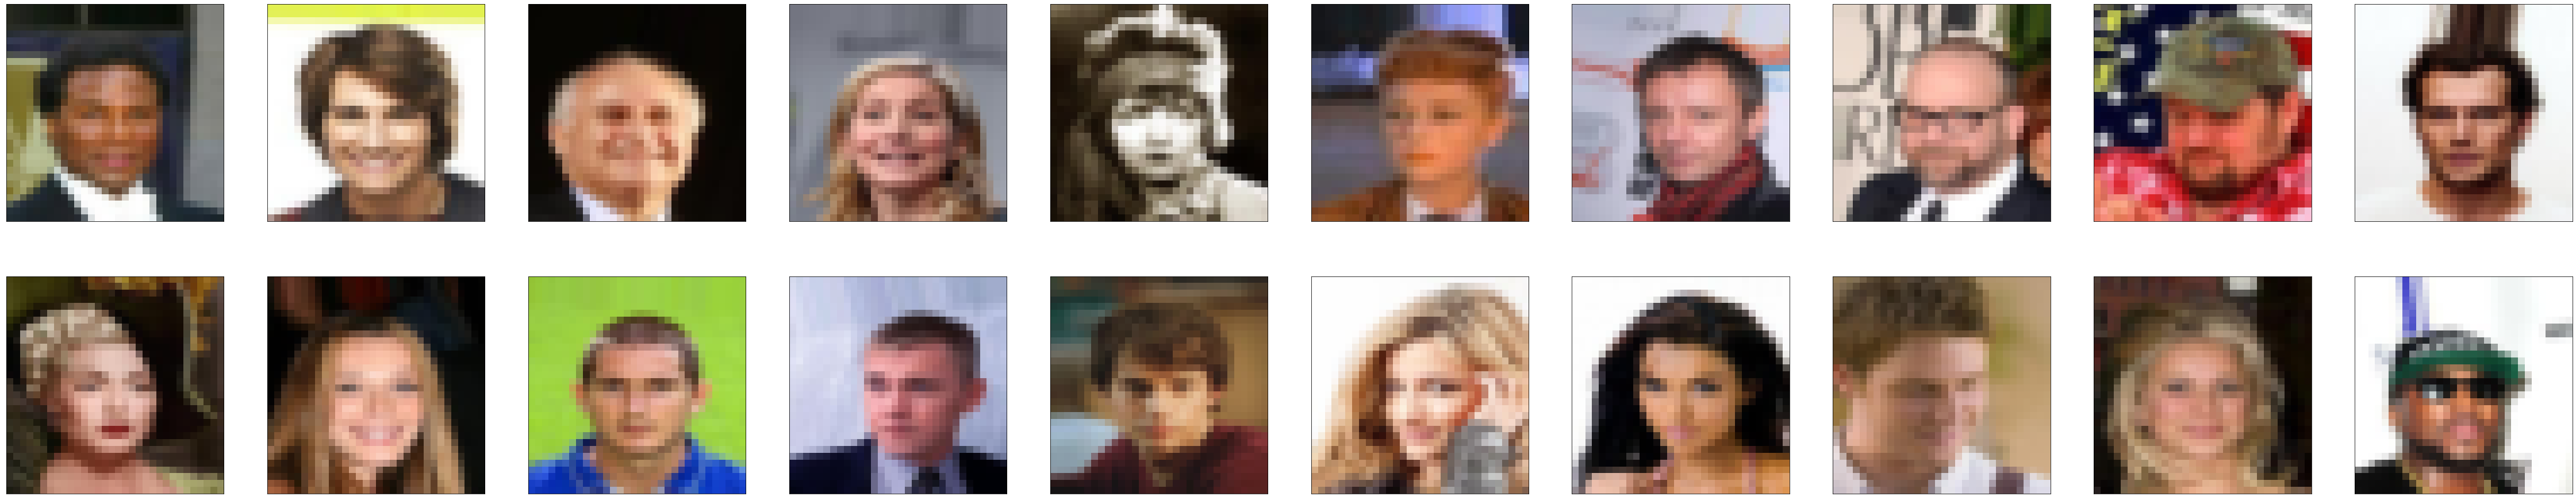

In [9]:
# Obtain one batch of training images
dataiter = iter(dataloaders)
images, _ = dataiter.next()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(80, 16))

plot_size = 20

for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

## 2. Model Architecture

### 2.1 Discriminator

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()

        self.kernel_size = 4
        
        # The depth of the first convolutional layer
        self.conv_dim = conv_dim

        # Input: 32x32x3 | Output: 16x16x64
        self.conv1 = nn.Conv2d(3, conv_dim, self.kernel_size, stride=2, padding=1, bias=False)
        
        # Input: 16x16x64 | Output: 8x8x128
        self.conv2 = nn.Sequential(*[
            nn.Conv2d(conv_dim, conv_dim*2, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*2)
        ])

        # Input: 8x8x128 | Output: 4x4x256
        self.conv3 = nn.Sequential(*[
            nn.Conv2d(conv_dim*2, conv_dim*4, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*4)
        ])

        # Input: 4x4x256 | Output: Logit (0-1)
        self.output_layer = nn.Linear(conv_dim*4*4*4, 1)

        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x))
        out = self.dropout(out)
        out = F.leaky_relu(self.conv2(out))
        out = self.dropout(out)
        out = F.leaky_relu(self.conv3(out))
        out = self.dropout(out)
        flattened_output = out.view(-1, self.conv_dim*4*4*4)        
        out = self.output_layer(flattened_output)
        
        return out

### 2.2 Generator

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()

        # The depth of the inputs to the *last* transpose convolutional layer
        self.conv_dim = conv_dim
        self.kernel_size = 4
        
        self.input_fc_layer = nn.Linear(z_size, conv_dim*4*4*2)
        
        # Upsampling Transpose Convolutional Layers
        # Input: 2x2x512 | Output: 4x4x256
        self.tconv1 = nn.Sequential(*[
            nn.ConvTranspose2d(conv_dim*8, conv_dim*4, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*4)
        ])

        # Input: 4x4x256 | Output: 8x8x128
        self.tconv2 = nn.Sequential(*[
            nn.ConvTranspose2d(conv_dim*4, conv_dim*2, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*2)
        ])

        # Input: 8x8x256 | Output: 16x16x128
        self.tconv3 = nn.Sequential(*[
            nn.ConvTranspose2d(conv_dim*2, conv_dim, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim)
        ])

        # Input: 16x16x128 | Output: 32x32x3
        self.output_tconv = nn.ConvTranspose2d(conv_dim, 3, self.kernel_size, stride=2, padding=1, bias=False)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        out = self.input_fc_layer(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) # output dimension: 2x2x256
        out = F.relu(self.tconv1(out))
        out = F.relu(self.tconv2(out))
        out = F.relu(self.tconv3(out))
        # out = F.tanh(self.output_tconv(out))
        out = torch.tanh(self.output_tconv(out))
        
        return out

### 2.3 Loss Function

In [12]:
def real_loss(D_out):
    """
    Calculate loss of "real image"
    Smaller value means the network predict real image better
    """

    batch_size = D_out.size(0)

    labels = torch.ones(batch_size)

    if device.type == 'cuda':
        labels = labels.cuda()

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    """
    Calculate loss of "fake image"
    Smaller value means the network predict real fake better
    """

    batch_size = D_out.size(0)

    # Create Fake Labels
    labels = torch.zeros(batch_size)
    
    if device.type == 'cuda':
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## 3. Training

In [13]:
def weights_init_normal(m):
    """
    Apply initial weights to certain layers in a model.
    The weights are taken from a normal distribution
        with mean = 0, std dev = 0.02.
    
    Parameter
    ---------
    m : Class(?)
        A module or layer in a network    
    """
    # Classname example: 'Conv', 'BatchNorm2d', 'Linear, etc
    classname = m.__class__.__name__

    # Apply initial weights to convolutional and linear layers
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        print('Updating Weight | ' + str(classname))
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

### Optimizer & the other Hyperparameter

In [14]:
# Define the hyperparameters

# Number of epochs
n_epochs = 5

# Learning Rate
lr = 0.0002

# Hyperparameter to control the first moment decay of the ADAM optimizer.
beta1 = 0.5

# Hyperparameter to control the second moment decay of the ADAM optimizer.
beta2 = 0.999

# The input size to the Discriminator
d_conv_dim = 64

# Input size to Transpose Convolution layer of Generator
g_conv_dim = 64

# First input (random noise) size  to the Generator
z_size = 100

# Build the network
D = Discriminator(d_conv_dim)
G = Generator(z_size, g_conv_dim)

# Initialize model weights
D.apply(weights_init_normal)
G.apply(weights_init_normal)

# Set the optimizer
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

Updating Weight | Conv2d
Updating Weight | Conv2d
Updating Weight | Conv2d
Updating Weight | Linear
Updating Weight | Linear
Updating Weight | ConvTranspose2d
Updating Weight | ConvTranspose2d
Updating Weight | ConvTranspose2d
Updating Weight | ConvTranspose2d


In [15]:
print(D)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Linear(in_features=4096, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [16]:
print(G)

Generator(
  (input_fc_layer): Linear(in_features=100, out_features=2048, bias=True)
  (tconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_tconv): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [17]:
def train(D, G, n_epochs, print_every=50):
    """
    Trains adversarial networks for some number of epochs

    Parameters
    ----------
    D : Class
        The Discriminator network
    G : Class
        The Generator network
    n_epochs : int
        Number of epochs to train for
    print_every : int 
        Which iteration to print and record the models' losses
        The default value is 50
    
    Return
    ------
    losses : List
        Tuple of the loss of Discriminator and Generator
    
    """

    if device.type == 'cuda':
        D.cuda()
        G.cuda()

    # Sample of fake image generated by the Generator
    samples = []
    # The output from the Generator is (sample_size, 3, image_size, image_size)
    sample_size = 16
    
    # Contain tuples of the loss of Discriminator and Generator
    losses = []
    
    # Define random noise
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()

    optim_updated = False
    
    if device.type == 'cuda':
        fixed_z = fixed_z.cuda()

    for epoch in range(n_epochs):
        for batch_i, (real_images, _) in enumerate(dataloaders):

            batch_size = real_images.size(0)
            # real_images = scale(real_images)
            
            # Train the Discriminator on real and fake images
            # ===============================================
            
            # Reset the previous gradient calculation
            d_optimizer.zero_grad()

            if device.type == 'cuda':
                real_images = real_images.cuda()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            # print("D_real_loss: " + str(d_real_loss.item()))
            
            # Fake images | Creating latent vectors similarly to fixed_z above
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if device.type == 'cuda':
                z = z.cuda()
                
            # Generate fake images from the latent vectors
            fake_images = G(z)
            
            # Discriminator Loss on Fake Images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            # print('D_fake_loss: ' + str(d_fake_loss.item()))
            
            # Total Discriminator Loss
            d_loss = d_real_loss + d_fake_loss
            
            # Optimize the network
            d_loss.backward()
            d_optimizer.step()


            # Train the generator with an adversarial loss
            # ============================================
            g_optimizer.zero_grad()
            
            # Generate latent vectors
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if device.type == 'cuda':
                z = z.cuda()
            
            # Generate fake images
            fake_images = G(z)
            
            # Compute Adversarial Loss from discriminator with flipped labels
            # Fake image input into real loss
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
            # Optimize the network
            g_loss.backward()
            g_optimizer.step()
            
            # Set lower learning rate/beta1 value for fine-tuning network after 10 epochs
            if (epoch + 1) == 10 and (not optim_updated):
                for param_group in g_optimizer.param_groups:
                    param_group['lr'] = 0.0001
                    param_group['betas'] = (0.1,beta2)
                for param_group in d_optimizer.param_groups:
                    param_group['lr'] = 0.0001
                    param_group['betas'] = (0.1,beta2)
                optim_updated = True
                print('Updated optimizers | lr = 0.0001 | Beta1 = 0.1')
            
            # End of the code
            # ===============

            # Print some loss stats
            if batch_i % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))

        # After each epoch
        # Generate sample images
        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z)

        G.train()

    '''
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)    
    '''

    # Save the entire network
    torch.save(G, './Generator')

    return losses

In [ ]:
losses = train(D,G,11)

Epoch [    1/   11] | d_loss: 0.7600 | g_loss: 1.4127
Epoch [    1/   11] | d_loss: 1.0252 | g_loss: 2.5435
Epoch [    1/   11] | d_loss: 0.6278 | g_loss: 2.1858
Epoch [    1/   11] | d_loss: 0.7150 | g_loss: 1.9261
Epoch [    1/   11] | d_loss: 0.7394 | g_loss: 1.2596
Epoch [    1/   11] | d_loss: 0.6866 | g_loss: 3.2476
Epoch [    1/   11] | d_loss: 0.7358 | g_loss: 2.0715
Epoch [    1/   11] | d_loss: 0.6693 | g_loss: 2.0844
Epoch [    1/   11] | d_loss: 0.5976 | g_loss: 1.3370
Epoch [    1/   11] | d_loss: 0.7183 | g_loss: 1.8163
Epoch [    1/   11] | d_loss: 0.8648 | g_loss: 1.7758
Epoch [    1/   11] | d_loss: 1.4098 | g_loss: 0.5862
Epoch [    1/   11] | d_loss: 0.6073 | g_loss: 2.7933
Epoch [    1/   11] | d_loss: 0.7543 | g_loss: 2.2842
Epoch [    1/   11] | d_loss: 0.8504 | g_loss: 2.3218
Epoch [    1/   11] | d_loss: 0.6519 | g_loss: 2.2387
Epoch [    1/   11] | d_loss: 0.6721 | g_loss: 1.7934
Epoch [    1/   11] | d_loss: 0.8225 | g_loss: 1.9531
Epoch [    1/   11] | d_loss

# 4. Evaluation

## 4.1. Loss visualization

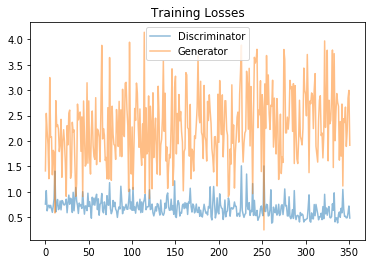

In [58]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## 4.2. Plotting Output Image

In [59]:
# Generate sample image
samples = []

for i in range(1):
    fixed_z = np.random.uniform(-1, 1, size=(16, 100))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    if device.type == 'cuda':
        fixed_z = fixed_z.cuda()
    
    # Flatten the output into 1x sample_size image
    for j in G(fixed_z):
        samples.append(j)

In [60]:
# Scale up 2x, then center crop the image
# We don't want resize too much since the output image is already low-resolution image (32x32)
# This will create too much artifact
# The final image has same size as output from Generator
center_crop = transforms.CenterCrop(32)

samples_center_cropped = []
for idx, i in enumerate(samples):
    img = i.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = ((img + 1)*255 / (2)).astype(np.uint8)
    img = cv2.resize(img, (64,64))
    img = center_crop(PIL.Image.fromarray(img))
    samples_center_cropped.append(img)
    # or to save in file, comment the line above
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # cv2.imwrite('./results/'+str(idx)+'.png', img)

In [54]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):#[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img)

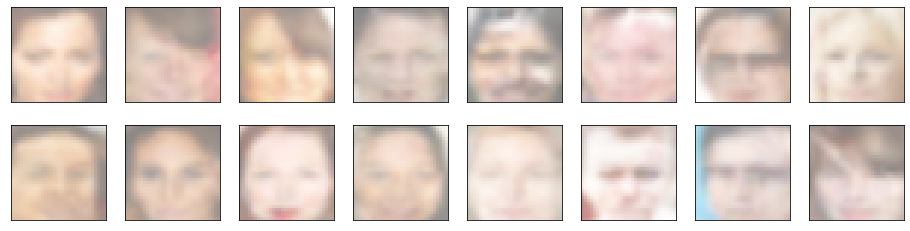

In [61]:
# This is the sample of images generated by model which was trained for 15 epochs
view_samples(-1, samples_center_cropped)